### <span style="color: Gold">  **Dense Vector Search (밀집벡터 검색)**

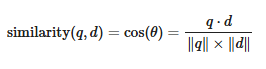
- 원리 : 문장을 고차원 벡터로 변환하고 cosine 유사도를 이용해서 의미적 유사성을 측정
- 장점
    - 의미적 유사성 포착 (동의어)
    - ex. 비가 온다 ==> 장마가 시작됐다 
- 단점
    - 고유명사, 숫자 등 정확한 매칭에 약해

### <span style="color: Gold"> **BM25**

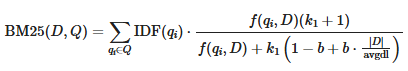
- IDF(qᵢ): 단어 qᵢ의 역문서 빈도 (드문 단어일수록 값이 큼)
- tf(qᵢ, D): 문서 D에서 단어 qᵢ가 등장한 횟수
- k₁: 포화 파라미터 (일반적으로 1.2 ~ 2.0)
- b: 문서 길이 정규화 파라미터 (일반적으로 0.75)
- avgdl: 전체 문서들의 평균 길이

<br>

- 키워드 기반 희소 검색
- TF-IDF 의 개선버전, 문서 내 단어 빈도와 희소성을 고려
- 어떻게 동작?
    - 문서를 “단어”로 쪼갬
    - 쿼리 단어가 문서에서 얼마나 많이 나오는지(빈도)
    - 그 단어가 전체 문서 중 얼마나 희귀한지(IDF)
    - 문서 길이는 얼마나 되는지(길이가 너무 길면 불리하게 조정)

- 장점
    - 정확한 키워드 매칭
    - 고유명사 검색에 강함
- 단점
    - 의미적 유사성 포착이 불가능
    - ex. 비에서 장마로 연결이 어렵거나 불가능함

### <span style="color: Gold">  **Reciprocal Rank Fusion (RRF)**

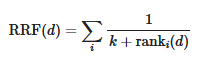
- d: 문서
- k: 상수 (일반적으로 60 사용 - 순위도가 낮은 문서도 완전히 0이 되지 않게 안정화)
- rankᵢ(d): i번째 검색 시스템에서 문서 d가 받은 순위

<br>

- 여러 검색 시스템에서 나온 문서 순위(rank)를 통합하여 최종 점수를 계산하는 방법
   <br> (혼자 쓸수 없고, 앞단의 검색결과를 통합해서 사용. ref. 앙상블 voting과 유사)
- 각 시스템에서 문서의 순위가 높을수록 (즉, rank 값이 작을수록) 점수가 커진다.
- 순위를 뒤집어서 reciprocal하게 점수 계산 → 순위가 높을수록 더 큰 영향
- 장점
    - 다양한 검색 방식의 장점 결합
    - 점수 스케일이 다른 검색결과도 통합이 가능
- 단점
    - 개별 점수를 직접 사용하지 않고 순위만 이용 → 세부 점수 차이는 무시

<br>

- 🔹 RRF는 검색 방법 자체라기보다는, 검색 결과 통합 방법이에요.
- Dense Search / BM25 / 다른 검색 시스템 → 나온 순위를 RRF로 합치는 것
- 즉, 하이브리드 검색을 만들 때 마지막 단계에서 순위를 통합하는 역할

### <span style="color: Gold">  **Hybrid Search**
- BM25 점수
- Dense Search 점수
- RRF로 섞어서 최종 검색 순위를 만든 것.
- 그래서 BM25 단어 기반 + Embedding 의미 기반 둘 다 챙기는 검색.

In [ ]:
# %pip install faiss-cpu

##  <span style="color: Gold"> **Dense Vector Search (밀집벡터 검색)**

In [8]:
# 문장 임베딩으로 벡터 검색
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# 한국어 임베딩 모델 로드
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')  #768차원 벡터로 변환해주는 모델
# sample doc
documents = [
    "올해 여름 장마가 시작됐다",
    "프린스턴 대학교에서 학위를 받았다",
    "갤럭시 S5가 출시됐다"
]
# 문서 임베딩
doc_embeddings = model.encode(documents) # shape (3,768)

# FAISS 인덱스 생성
dimension = doc_embeddings.shape[1]  # doc_embeddings.shape (3,768)
index = faiss.IndexFlatL2(dimension) # IndexFlatL2 = 유클리드 거리(L2 거리) 기반 최근접 검색 인덱스, k-NN 검색 가능
index.add(doc_embeddings.astype('float32'))

# 쿼리 생성 및 쿼리 임베딩
query = '비가 많이 올 시기는?'
query_embedding = model.encode([query])
distance, indices = index.search(query_embedding.astype('float32'), k=3)  
# k=3 상위 3개 
# 쿼리 벡터와 모든 문서의 벡터의 거리 (L2) 계산
# 거리 값이 작은 순으로 정렬
# distance → 거리 값  # indices → 어떤 문서가 선택됐는지 (문서 인덱스)

print('=== 검색 결과 ==')
for i, (dist, idx) in enumerate ( zip(distance[0], indices[0]) ):
    print(f' {i+1}, {documents[idx]} ( 거리 : {dist:.4f} ) , 인덱스 : {idx}')

### 검색결과
# cosine 유사도로 찾기 때문에 거리가 짧을수록 유사하다(가깝다)라고 볼 수 있음
# indices[0]는 [0, 2, 1] 처럼 문서 순서 --> 쿼리와 가장 유사한 문서들의 인덱스 번호
# distance는 L2 거리 → 작을수록 더 유사

=== 검색 결과 ==
 1, 올해 여름 장마가 시작됐다 ( 거리 : 391.9999 ) , 인덱스 : 0
 2, 갤럭시 S5가 출시됐다 ( 거리 : 702.7927 ) , 인덱스 : 2
 3, 프린스턴 대학교에서 학위를 받았다 ( 거리 : 717.1246 ) , 인덱스 : 1


##  <span style="color: Gold"> **BM25**

In [ ]:
### GPT 수정 ###
# 1. 문서를 토크나이징
# 2. IDF(역문서빈도) 계산
# 3. 쿼리가 들어오면:
    # 쿼리 토큰 분해
    # 각 문서의 BM25 점수 계산
    # 문서별 유사도 점수를 리스트로 반환


import math
from collections import defaultdict
from transformers import AutoTokenizer

class SimpleBM25:
    def __init__(self, documents, k1=1.2, b=0.75):
        # k1: 토큰이 반복해서 나올 때 얼마나 더 점수를 증가시킬지 결정
        # b: 문서 길이에 따른 점수 보정 (길면 불리함)

        # 토크나이저
        self.tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
        self.k1 = k1
        self.b = b

        # 문서 저장 & 토크나이징
        self.documents = documents
        self.tokenized_docs = [self.tokenizer.tokenize(doc) for doc in documents]

        # 평균 문서 길이 계산 BM25의 b 파라미터에 사용됨
        self.avg_doc_len = sum(len(doc) for doc in self.tokenized_docs) / len(self.tokenized_docs)

        # BM25에서 중요한 희귀 단어일수록 점수를 높게 주는 요소
        self.idf = self._compute_idf()


    # =======================
    # 🎯 _compute_idf() 설명
    # =======================
    def _compute_idf(self):
        N = len(self.tokenized_docs)  # 전체 문서 수

        # df 계산 (document frequency 문서 빈도 계산)
        df = defaultdict(int) # defaultdict ==> 딕셔너리에 전부 0으로 채워져 있음
        for doc in self.tokenized_docs:
            for token in set(doc):  # 중복방지를 위해서 set으로 
                df[token] += 1
        
        # IDF 계산
        idf = {}
        for token, freq in df.items():  #df.items() key 단어 token, value 단어가 등장한 문서수 (빈도수) freq ex. df = {'장마': 2, '대학교': 1, '갤럭시': 1}
            # BM25의 안정화된 IDF
            idf[token] = math.log((N - freq + 0.5) / (freq + 0.5) + 1)  
            # freq: 해당 token이 등장한 문서수
            # N - freq : 토크나이저 doc에서 등장빈도 빼면 토큰이 등장하지 않는 문서의 수
            # + 0.5 : 분모분자 안정화 (smoothing)
            # 분자 : 토큰이 나타나지 않은 문서수 
            # 분모 : 토큰이 등장한 문서수
            # 희귀한 토큰일 수록 N-freq/freq 비율이 커짐 (IDF 높게)--> 값 증가. //  흔한 토큰일수록 작아짐  (IDF 낮게)           

        return idf


    # ====================
    # 🎯 score(query) 설명
    # ====================
    def score(self, query):
        # 쿼리 토큰화
        query_tokens = self.tokenizer.tokenize(query)

        # 각 문서를 순회하며 점수 계산        
        scores = []
        for doc in self.tokenized_docs:
            doc_len = len(doc) # 문서 길이

            # 해당 문서의 토큰 빈도 계산 (tf 계산 term frequency)
            tf = defaultdict(int)
            for token in doc:
                tf[token] += 1

            # 각 쿼리 토큰별 문서에 기여하는 점수 계산
            score = 0
            for token in query_tokens: # 쿼리에 있는 단어(token)를 순회하며 쿼리 단어가 문서에 등장했는지를 기준으로 점수 계산
                if token not in tf:
                    continue
                    # tf = 현재 문서에서 각 단어가 몇 번 등장했는지 저장한 딕셔너리
                    # 만약 쿼리 단어가 문서에 아예 없으면 계산할 필요가 없으므로 건너뜀
                    # continue = 바로 다음 토큰으로 넘어감
                
                freq = tf[token]   # 해당 토큰이 문서 안에서 몇 번 등장했는지 TF(Term frequency) 역할
                idf = self.idf.get(token, 0)  # IDF(역문서빈도) 가져오기 / 드물게 등장하는 단어일수록 값이 큼 -> 문서 점수에 더 큰 영향

                numerator = freq * (self.k1 + 1)
                denominator = freq + self.k1 * (1 - self.b + self.b * (doc_len / self.avg_doc_len))

                score += idf * (numerator / denominator) # (numerator / denominator)  TF 기반 점수 조정
                                # 단어별 점수를 IDF로 가중치 # 여러 쿼리 토큰 점수를 합쳐서 문서 전체 점수 완성
                                # numerator : 문서에서 특정 단어가 얼마나 많이 나왔는지를 증폭시킨 값 / 많이 나오면 점수가 커지고, 적게 나오면 점수가 작음 / 쉽게 말하면: "단어 등장 횟수 × 보정 상수"
                                # denominator : 단어 등장 횟수를 문서 길이에 따라 조정한 값 / 문서가 길면 점수를 줄이고, 문서가 짧으면 점수를 높임 / 쉽게 말하면: "단어 빈도 + 문서 길이 보정"
            scores.append(score)

        return scores



# 최종 의미
# 한 문서의 BM25 점수 = 쿼리 단어가 문서에 얼마나 포함되어 있는지 + 단어 희귀도 + 문서 길이 보정 → 계산된 값
# 검색할 때 모든 문서 점수를 계산하고, 점수가 높은 순서대로 정렬 → 최종 검색 결과

In [2]:
# bm25 사용 예시
documents = [
    "로버트 헨리 딕이 1946년에 연구했다",
    "2023년 AI 기술이 발전했다",
    "프린스턴 대학교 AI 연구소",
    "프린스턴 대학교 일반 대학원"
]

bm25 = SimpleBM25(documents)
query = "프린스턴 대학교"
scores = bm25.score(query)
print(scores)

# 점수 높은게 유사도가 높음
# 유사도를 보는것이 아니라서.. 고유명사 인게 score가 잘 나옴

[0, 0, 2.354661745725697, 2.354661745725697]


##  <span style="color: Gold"> **rrf ( hybrid_search )**

In [ ]:
def reciprocal_rank_fusion(rankings, k=60):
    '''
    여러검색 결과의 순위를 RRf로 통합
    Args:
        rankings : 각 검색방식의 문서 인덱스 순위 리스트
        k : 상수
    Return:
         통합 점수로 정렬된(문서인덱스, 점수) 리스트
    '''
    rrf_scores = defaultdict(float)
    for ranking in rankings :  # rankings = 여러 검색 시스템에서 나온 문서 순위 리스트 #예: [dense_ranking, sparse_ranking]
        for rank, doc_id in enumerate(ranking, 1):
            rrf_scores[doc_id] += 1.0 / (k+rank)  # 문서별로 점수를 누적 # rank가 높으면 점수가 작음, 낮으면 점수가 큼
    return sorted(rrf_scores.items(), key=lambda x : x[1], reverse= True) # 마지막으로 점수 기준 내림차순 정렬 → 최종 순위



def hybrid_search(query,dense_index, documents, bm25, top_k=3, rrf_k=60):

    # Dense Search FAISS
    query_embedding = model.encode([query])  # 쿼리를 벡터로 변환
    D,I =  dense_index.search(query_embedding.astype('float32'), k=top_k) # FAISS 인덱스에서 거리 기준 상위 k개 문서 검색
    dense_ranking = list(I[0])   # Dense Search 결과 순서
    print(f'dense_ranking : {dense_ranking}')

    # BM25
    sparse_scores = bm25.score(query)
    sparse_ranking = list(np.argsort(sparse_scores)[::-1][:top_k]) # 점수기준 k개 문서 선택
    print(f'sparse_ranking : {sparse_ranking}')


    # RRF 통합
    results = reciprocal_rank_fusion([dense_ranking, sparse_ranking], k=rrf_k)
    return results

In [ ]:
a = defaultdict(int)
a['a']+=1
a

# defaultdict 하면 딕트가 비워져 있어도 알아서 'a' 키를 넣고 value 1 이 들어감

defaultdict(int, {'a': 1})

In [ ]:
b = dict()
b['a'] += 1
b

# 딕트가 아예 비워져있기 때문에 오류가 남

KeyError: 'a'

In [13]:
b = dict()
b['a'] = b.get('a', 0) + 1
b

{'a': 1}

In [ ]:
# 문장 임베딩으로 벡터 검색
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

documents = [
    "올해 여름 장마가 시작됐다",
    "프린스턴 대학교에서 학위를 받았다",
    "갤럭시 S5가 출시됐다"
]

# 한국어 SBERT 모델
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
doc_embeddings = model.encode(documents).astype('float32')
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

bm25 = SimpleBM25(documents)

# 하이브리드 검색
query = '프린스턴 대학'
results = hybrid_search(query, index, documents, bm25, top_k=3)

print(f'하이브리드 검색 결과')
for rank, (doc_id, score) in enumerate(results, 1):
  try:
    print(f'{rank}. {documents[doc_id]} (점수 : {score:.4f})')
  except:
    pass

하이브리드 검색 결과
1. 프린스턴 대학교에서 학위를 받았다 (점수 : 0.0328)
2. 올해 여름 장마가 시작됐다 (점수 : 0.0320)
3. 갤럭시 S5가 출시됐다 (점수 : 0.0320)


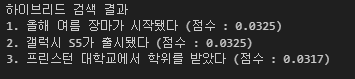